# Testing state abstraction of Ott's data

While we aim to collect a whole new data set for this project, we can nontheless test whether our state abstraction model of existing data. The design we aim to use is adapted Ott et al.'s design. For our purpose, we will increase the number of states compared to the original, to make it more difficult for participants to solve the MDP to push them to resort to abstraction. Therefore, the original design is not necessarily geared toward state abstraction. Nonetheless, participants were observed to behave suboptimally in the original design, which might indicate that already the state space size of the original study might be too large for participants to deal with. We can therefore test our state abstraction model on these data. First, we will compute the pairwise distances of each states in the original state space, generate abstracted MDP at various $\epsilon$ levels ($\epsilon=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]$) and compare the results of that model to the model from Ott et al.

## Compute pairwise distances:

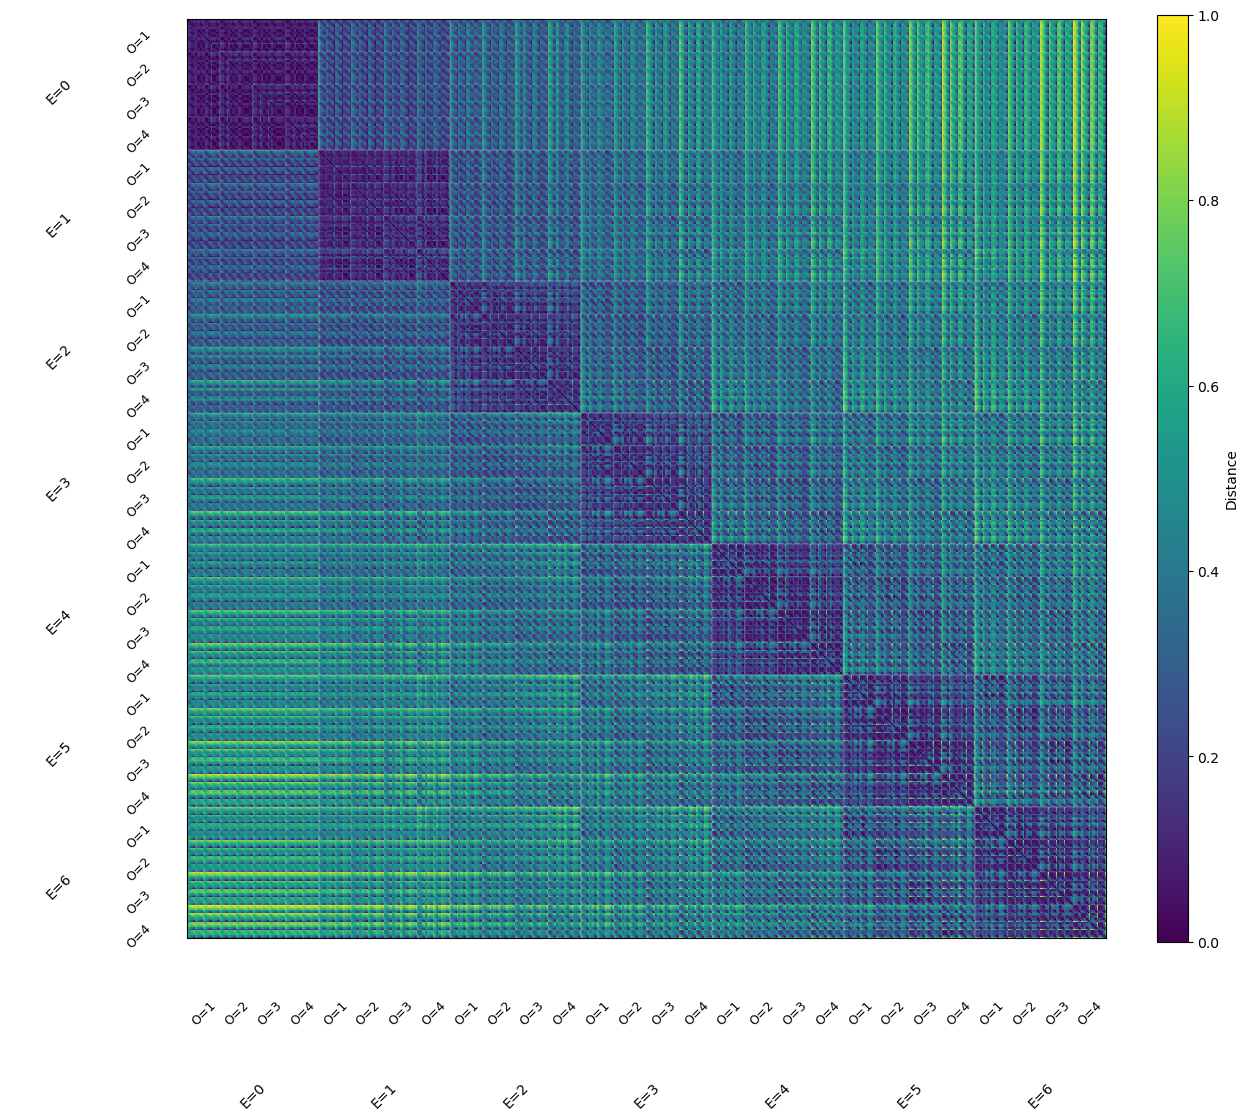

In [6]:
import numpy as np
import pandas as pd
import os
from stabst.utils import plot_state_matrix, abstract2ground_value
from stabst.MarkovDecisionProcess import MDP
from stabst.TaskConfig import LimitedEnergyTask
import matplotlib.pyplot as plt
import pymc as pm

# Create the task and its parameters (transition probability, reward...):
task = LimitedEnergyTask(O=[1, 2, 3, 4], p_offer=[1/4] * 4)
task.build()

# Create full MDP and compute solution for later reference:
task_mdp = MDP(task.states, task.tp, task.r, s2i=task.s2i)
V_full, Q_full = task_mdp.backward_induction()
R_full = task_mdp.expected_return(task_mdp.greedy_policy(Q_full), initial_energy=3)

# Compute pairwise distances:
if not os.path.isfile('../data/distance_matrix_ott.npy'):
    distances_matrix = task_mdp.bisim_metric(task.tp, task.r, gamma=0.9, tol=1e-9, njobs=-1, max_iters=1000)
    distances_matrix = distances_matrix / np.max(distances_matrix)
    np.save('../data/distance_matrix_ott.npy', distances_matrix)
else:
    distances_matrix = np.load('../data/distance_matrix_ott.npy')

# Plot the distance matrix:
plot_state_matrix(distances_matrix, task.states, feature_names=["E", "O", "CC", "FC", "T"], depth=2)
plt.show()

# Compute decision values for each abstraction level:

In [ ]:
abstraction_levels = np.arange(0, 0.1, 0.001)
DVs = {f'eps: {eps:.3f}': None for eps in abstraction_levels}
for eps in abstraction_levels:
    # Abstraction of 0 = no abstraction
    if eps == 0:
        DVs[f'eps: {eps:.3f}'] = Q_full[:, 1] - Q_full[:, 0]
    else:
        # Generate abstracted MDP at that level of abstraction:
        abstract_mdp, state_classes, class_of_state = task_mdp.distance_reduce_mdp(eps, distance_matrix=distances_matrix)
        # Solve the MDP:
        V_R, Q_R = abstract_mdp.backward_induction()
        # Project back to full space:
        V_from_reduced, Q_from_reduced = abstract2ground_value(class_of_state, V_R, Q_R)
        # Add to decision values
        DVs[f'eps: {eps:.3f}'] = Q_from_reduced[:, 1] - Q_from_reduced[:, 0]

## Prepare data for model fitting:

In [8]:
# Download data from Florian's repo:
url = 'https://github.com/fmott/context_dependent_planning/blob/1.2/data/behaviour/data_all_participants_training_20220215120300.csv?raw=true'
data = pd.read_csv(url, on_bad_lines='skip')
# Remove nans:
data = data.dropna()
# Flip responses: 1 = accept:
data["response"] = np.abs(data["response"] - 1)
# Add a subject column:
sub_id = 1
for i, row in data.iterrows():
    if i > 10 and row[0] == 0:
        sub_id += 1
    data.at[i, 'subject'] = f'sub-{sub_id}'

# Get subject IDs:
subj_idx_raw, subj_labels = pd.factorize(data["subject"])
coords = {
    "observation": np.arange(len(data)),
    "subject": subj_labels,
}

transitions_costs = {
    0: [1, 1],
    1: [2, 1],
    2: [1, 2],
    3: [2, 2]
}
# Add the decision value associated with each epsilons:
for eps in abstraction_levels:
    # Get the decision value:
    dv = DVs[f'eps: {eps:.3f}']
    # Loop through each trial to set DV:
    dv_trials = []
    for trial_i, trial in data.iterrows():
        e, o, cc, t = trial.energy, trial.reward, trial.energy_cost, trial.trial
        fc = transitions_costs[trial.transition][1]
        dv_trials.append(dv[task.s2i[(e, o, cc, fc, t+1)]])
    data[f'DV-eps: {eps:.3f}'] = dv_trials

C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_75996\901822033.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if i > 10 and row[0] == 0:


## Fit original model:

In [9]:
traces = {}

with pm.Model(coords=coords) as binomial_regression_model:
    # Extract regressors:
    dv = pm.Data("DV", data["dv_planning"], dims="observation")  # Continuous: Decision value from dynamic programming model
    subj_idx = pm.Data("subj_idx", subj_idx_raw, dims="observation")  # Categorical: Subject index for random effect
    i_01 = pm.Data("I01", data["is_1"], dims="observation")  # Binary: Is first offer
    i_02 = pm.Data("I02", data["is_2"], dims="observation")  # Binary: Is second offer
    i_03 = pm.Data("I03", data["is_3"], dims="observation")  # Binary: Is third offer
    i_04 = pm.Data("I04", data["is_4"], dims="observation")  # Binary: Is fourth offer
    i_maxe = pm.Data("Imax", data["is_full_energy"], dims="observation")  # Binary: Special case of max energy
    i_mine_lc = pm.Data("IminE_LC", data["is_low_energy_LC"], dims="observation")  # Binary: Special case of energy too low to accept offer when cost is low
    i_mine_hc = pm.Data("IminE_HC", data["is_low_energy_HC"], dims="observation")  # Binary: Special case of energy too low to accept offer when cost is high

    # Hyperpriors (i.e. priors on fixed effects)
    # Parameters with random effects within subject:
    Bplan = pm.Normal('Bplan', mu=0, sigma=2)  # Beta for decision values
    sigma_Bplan = pm.HalfNormal('sigma_Bplan', sigma=2)  # Variance of Bplan across participants
    B01 = pm.Normal('B01', mu=0, sigma=2)  # Beta for bias associated with offer 1
    sigma_B01 = pm.HalfNormal('sigma_B01', sigma=2)  # Variance of B01 across participants
    B02 = pm.Normal('B02', mu=0, sigma=2)  # Beta for bias associated with offer 2
    sigma_B02 = pm.HalfNormal('sigma_B02', sigma=2)  # Variance of B02 across participants
    B03 = pm.Normal('B03', mu=0, sigma=2)  # Beta for bias associated with offer 3
    sigma_B03 = pm.HalfNormal('sigma_B03', sigma=2)   # Variance of B03 across participants
    B04 = pm.Normal('B04', mu=0, sigma=2)  # Beta for bias associated with offer 4
    sigma_B04 = pm.HalfNormal('sigma_B04', sigma=2)  # Variance of B04 across participants
    BmaxE = pm.Normal('BmaxE', mu=0, sigma=2)  # Beta for bias in max energy trials (no random effect across participants)
    BminE_LC = pm.Normal('BminE_LC', mu=0, sigma=2)  # Beta for bias in too low energy trials (no random effect across participants)
    BminE_HC = pm.Normal('BminE_HC', mu=0, sigma=2)  # Beta for bias in too low energy trials (no random effect across participants)
    
    # Within subject effects:
    bplan = pm.Normal('bplan', mu=Bplan, sigma=sigma_Bplan, dims="subject")  # Beta for decision value for each specific subject
    b01 = pm.Normal('b01', mu=B01, sigma=sigma_B01, dims="subject")  # Beta for offer 1 trial for each specific subject
    b02 = pm.Normal('b02', mu=B02, sigma=sigma_B02, dims="subject")  # Beta for offer 2 trial for each specific subject
    b03 = pm.Normal('b03', mu=B03, sigma=sigma_B03, dims="subject")  # Beta for offer 3 trial for each specific subject
    b04 = pm.Normal('b04', mu=B04, sigma=sigma_B04, dims="subject")  # Beta for offer 4 trial for each specific subject
    
    # Expected value (i.e. statistical model)
    mu = bplan[subj_idx] * dv + b01[subj_idx] * i_01 + b02[subj_idx] * i_02 + b03[subj_idx] * i_03 + b04[subj_idx] * i_04 + BmaxE * i_maxe + BminE_LC * i_mine_lc + BminE_HC * i_mine_hc
    pm.Bernoulli("y", logit_p=mu, observed=data["response"], dims="observation")
    traces[f'eps: {0}'] = pm.sample(1000, tune=1000, target_acceptance=0.9, idata_kwargs={"log_likelihood": True})


c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Bplan, sigma_Bplan, B01, sigma_B01, B02, sigma_B02, B03, sigma_B03, B04, sigma_B04, BmaxE, BminE_LC, BminE_HC, bplan, b01, b02, b03, b04]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 144 seconds.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


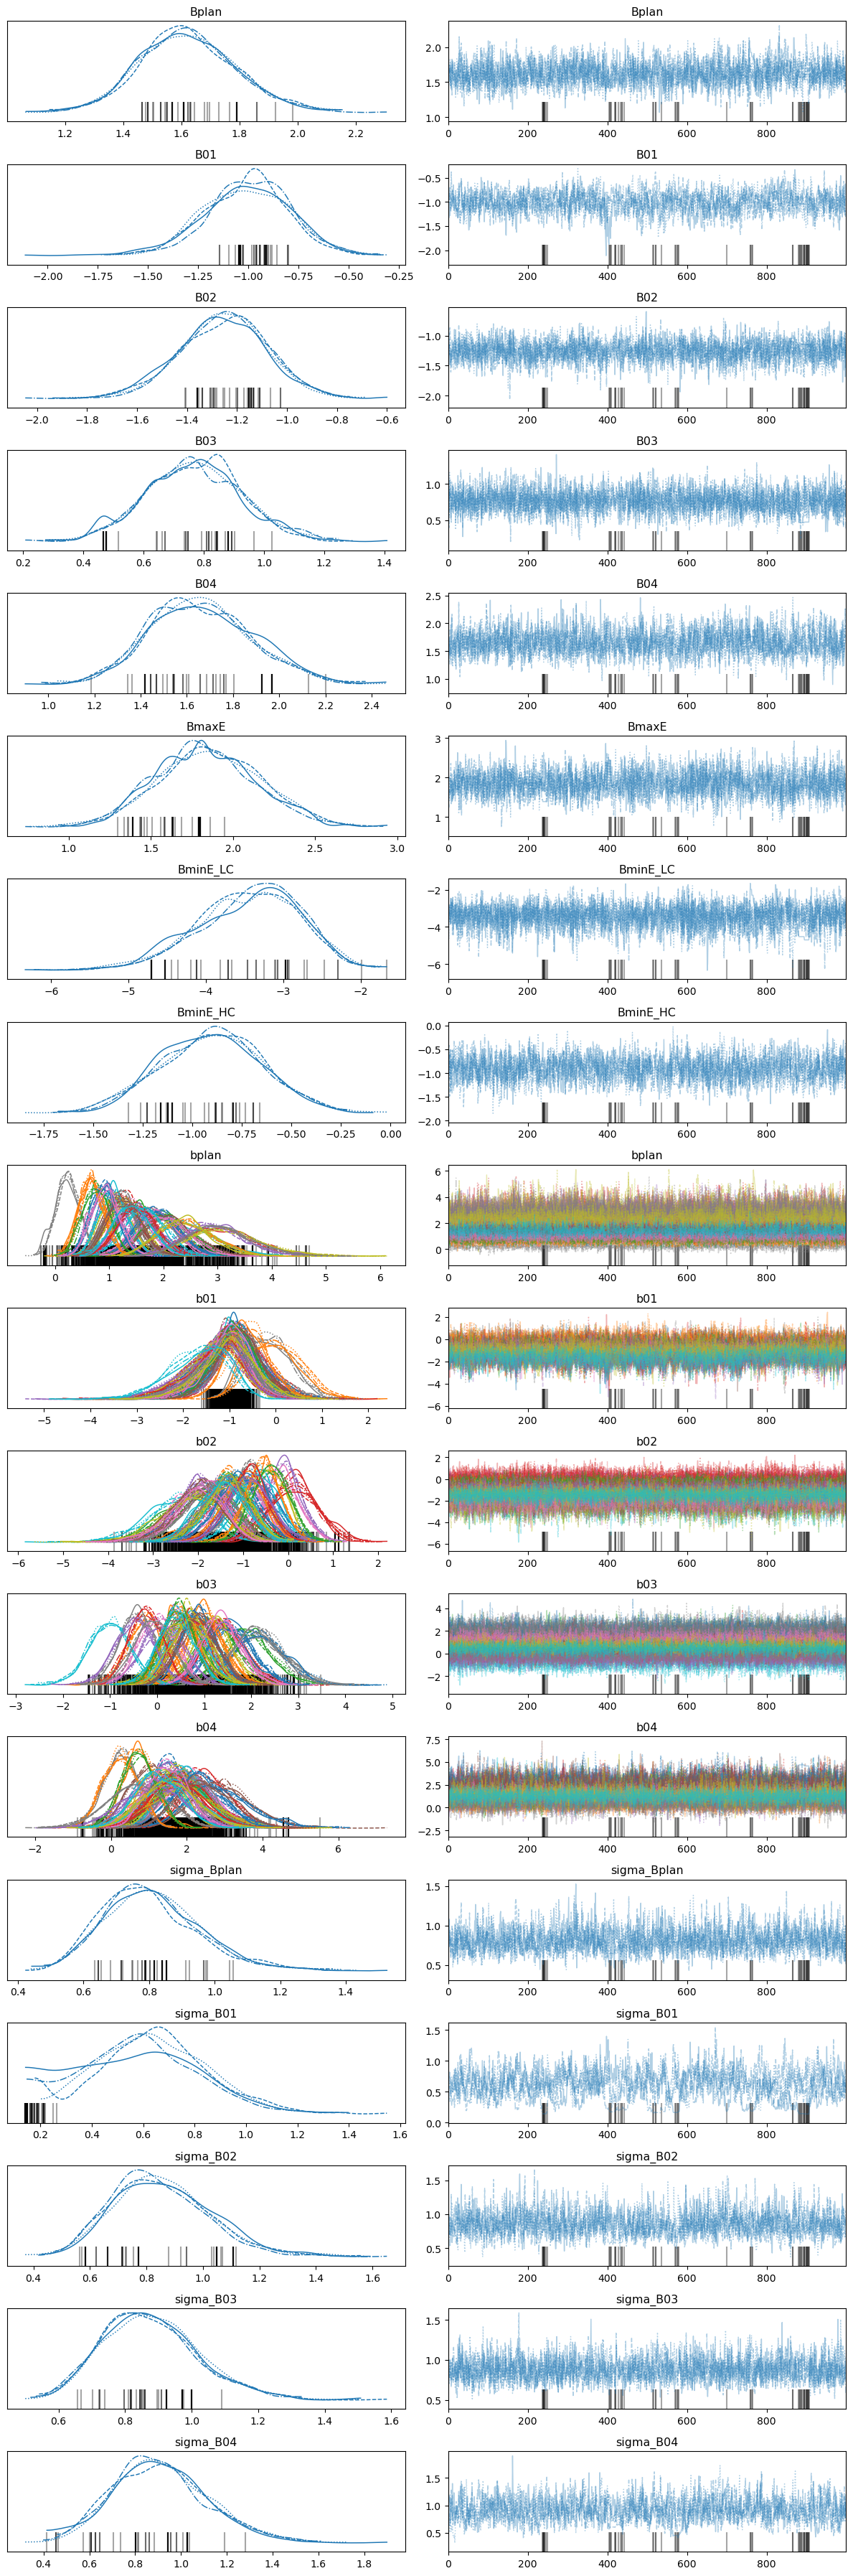

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Bplan        1.623  0.167   1.324    1.958      0.004    0.003    1608.0   
B01         -1.004  0.213  -1.405   -0.606      0.008    0.005     718.0   
B02         -1.255  0.174  -1.584   -0.927      0.004    0.003    2375.0   
B03          0.768  0.158   0.465    1.060      0.003    0.003    2819.0   
B04          1.662  0.222   1.266    2.092      0.006    0.003    1596.0   
...            ...    ...     ...      ...        ...      ...       ...   
sigma_Bplan  0.809  0.149   0.544    1.086      0.004    0.002    1700.0   
sigma_B01    0.607  0.225   0.141    0.962      0.016    0.008     172.0   
sigma_B02    0.855  0.175   0.560    1.191      0.006    0.003     776.0   
sigma_B03    0.877  0.143   0.616    1.145      0.003    0.002    2018.0   
sigma_B04    0.912  0.206   0.535    1.311      0.007    0.004     759.0   

             ess_tail  r_hat  
Bplan          2131.0   1.00  
B01            1282.0   1.01  
B02            2749.0   1.00  
B03            1001.0   1.00  
B04            2327.0   1.00  
...               ...    ...  
sigma_Bplan    2754.0   1.00  
sigma_B01       144.0   1.04  
sigma_B02       697.0   1.00  
sigma_B03      2842.0   1.00  
sigma_B04       655.0   1.01  

[213 rows x 9 columns]

In [10]:
az.plot_trace(traces[f'eps: {0}'])
plt.tight_layout()
plt.show()
az.summary(traces[f'eps: {0}'])

## Fit state abstraction models:

In [11]:
traces = {}
for eps in abstraction_levels:
    # Model the data:
    with pm.Model(coords=coords) as binomial_regression_model:
        x = pm.Data("DV", data[f'DV-eps: {eps:.3f}'], dims="observation")  # Continuous: Decision value from dynamic programming model
        subj_idx = pm.Data("subj_idx", subj_idx_raw, dims="observation")
        # Hyperpriors
        mu_b0 = pm.Normal('mu_b0', mu=0, sigma=2)
        sigma_b0 = pm.HalfNormal('sigma_b0', sigma=2)
        mu_b1 = pm.Normal('mu_b1', mu=0, sigma=2)
        sigma_b1= pm.HalfNormal('sigma_b1', sigma=2)
        
        # Intercept for each subject, distributed around group mean mu_b0
        b0 = pm.Normal('beta0', mu=mu_b0, sigma=sigma_b0, dims="subject")
        # Intercept for each subject, distributed around group mean mu_b1
        b1 = pm.Normal('beta1', mu=mu_b1, sigma=sigma_b1, dims="subject")
        
        # Expected value
        mu = b0[subj_idx] + b1[subj_idx] * x
        pm.Bernoulli("y", logit_p=mu, observed=data["response"], dims="observation")

        traces[f'DV, eps={eps:.3f}'] = pm.sample(1000, tune=1000, target_acceptance=0.9, idata_kwargs={"log_likelihood": True})

# Compare models:
model_comparison = az.compare(traces)

c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0, beta1]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b0, sigma_b0, mu_b1, sigma_b1, beta0, beta1]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.
There were 1112 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.
There were 299 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:/

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.
There were 371 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:/

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 659 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:/

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 1541 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
There were 626 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:/

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 108 seconds.
There were 481 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 274 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:/

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:/

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 98 seconds.
There were 264 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:/

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.
There were 1252 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 119 seconds.
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 345 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:/

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 110 seconds.
There were 216 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 101 seconds.
There were 1444 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 118 seconds.
There were 371 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
There were 714 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https:/

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influentia

c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\alexander.lepauvre\AppData\Local\miniforge3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.wa

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

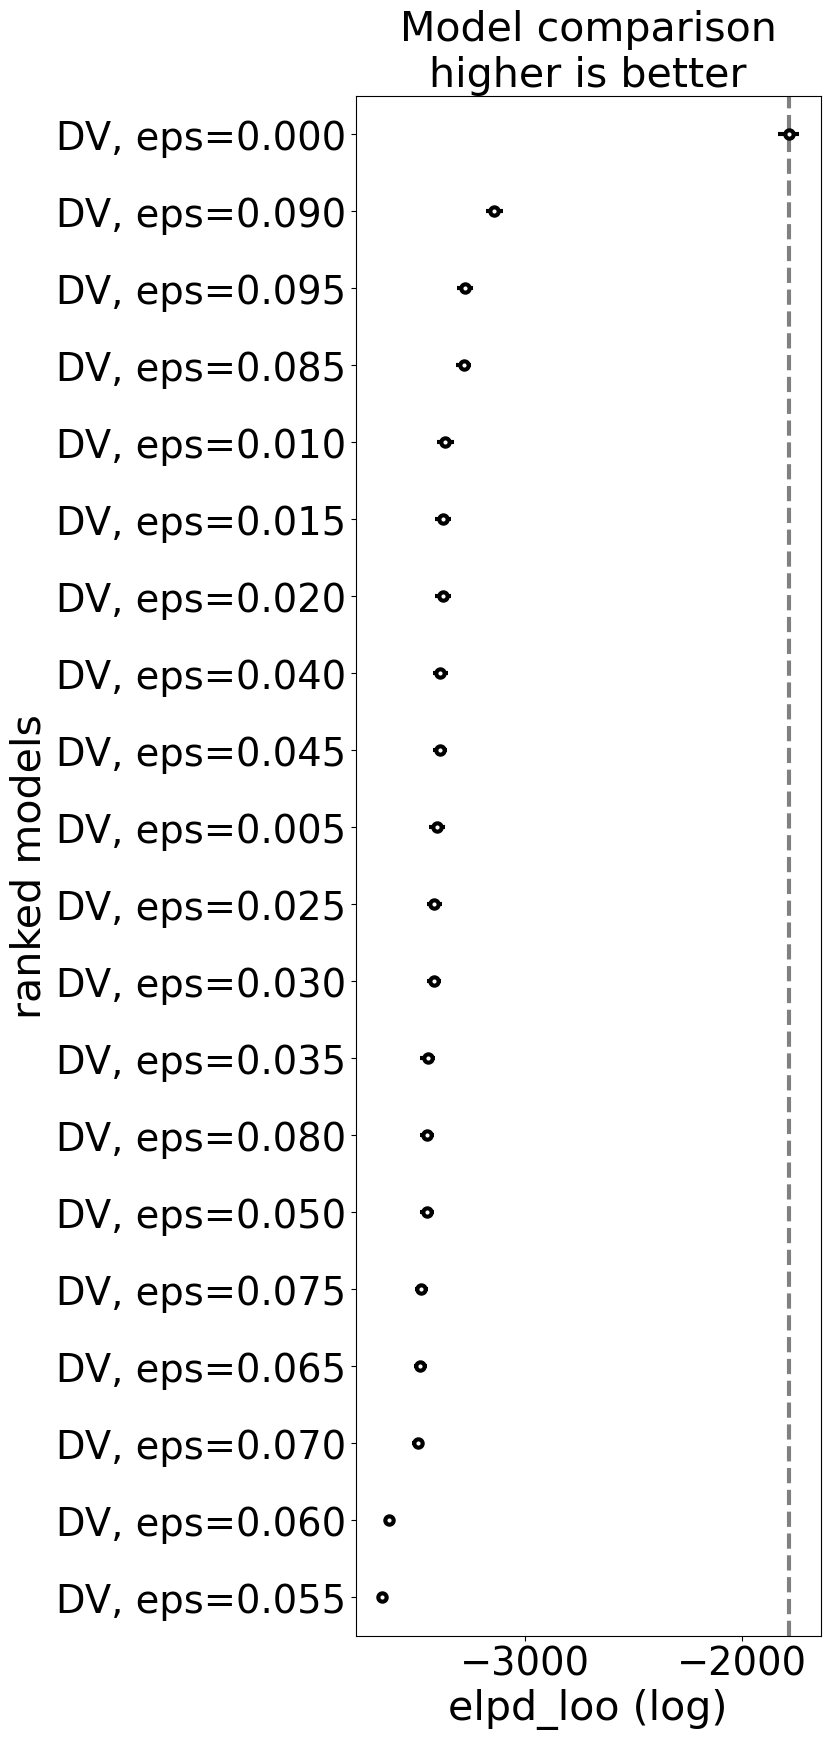

In [12]:
# Compare models:
model_comparison = az.compare(traces)
az.plot_compare(model_comparison)